# Introduction

Since Airbnb was founded in 2008, it has changed the hospitality and rental industry. Airbnb offers travellers from all over the world a fast and efficient way to search for long and short-term accomodations, as well as helping hosts to advertise to a much bigger audience. Given the reach and profitability of this venture, in this paper I found it interesting to explore the factors affecting the price of an Airbnb listing. 

### Importing libaries and dataset

In [48]:
import numpy
import pandas as pd

# one-hot encoding categorical variables
from sklearn.preprocessing import OneHotEncoder

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns

# model building
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

# for k-fold validation
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline 

# Importing dataset
df = pd.read_csv('AB_US_2020.csv')

# Exploratory Data Analysis

### Dataset

The dataset used is from an open task on Kaggle, called "U.S Airbnb Open Data".[^1] It was compiled by Kritik Seth from multiple datasets found on "Inside Airbnb". [^2] It contains 226030 rows and 17 columns. Each row represents an unique Airbnb listing. All of the listings shown are constrained to the U.S only. The description of the columns are as follows:

[^1]: https://www.kaggle.com/kritikseth/us-airbnb-open-data
[^2]: http://insideairbnb.com/index.html


| Column Name                    | Description                                              | Number of missing values |
|--------------------------------|----------------------------------------------------------|--------------------------|
| id                             | unique listing id                                        | 0                        |
| name                           | name of listing                                          | 28                       |
| host_id                        | unique host id                                           | 0                        |
| host_name                      | name of host                                             | 33                       |
| neighbourhood_group            | group in which the neighbourhood lies                    | 115845                   |
| neighbourhood                  | name of the neighbourhood                                | 0                        |
| latitude                       | latitude of listing                                      | 0                        |
| longitude                      | longitude of listing                                     | 0                        |
| room_type                      | type of room (Private, Shared, Entire home/apt, Rental)  | 0                        |
| price                          | price of listing per night                               | 0                        |
| minimum_nights                 | minimum number of nights required to book                | 0                        |
| number_of_reviews              | total number of reviews on listing                       | 0                        |
| last_review                    | date on which listing received its last review           | 48602                    |
| reviews_per_month              | average reviews per month on listing                     | 48602                    |
| calculated_host_listings_count | total number of listings by host                         | 0                        |
| availability_365               | number of days in year the listing is available for rent | 0                        |
| city                           | region of the listing                                    | 0                        |

### Previous Work

There has been multiple notebooks posted on this particular dataset. The most highly rated notebooks have all been on natural language processing. They have used the "name" column, which is a highly descriptive title for the listing, to predict the price of the listing. The highest rated notebook [^1] has used an ensemble of models containing random forest model and sequential embeddings model. The sequential embeddings model was a neural network of two dense layers with ReLu as the activation function. Altogether, the notebook has managed to achieve a root-mean-squared-error of 20, which means the predicted prices from the model are +/-  USD 20 than the actual prices. This notebook was also careful to prove that their model was not in danger of overfitting, even though they did not use any cross-validation techniques. 

In contrast, the second highest rated notebook [^2] uses the columns: 'neighbourhood_group','room_type', 'city', 'price', 'name', 'host_name', 'neighbourhood' to predict price. Through the use of a word tokenizer, they analyze the 'name' column and use it in their linear regression and random forest regressor models. They were able to achieve an RMSE of 0.04 through their random forest model, however, they do not use any cross-validation techniques.

[^1]: https://www.kaggle.com/thomaskonstantin/u-s-airbnb-analysis-and-price-prediction
[^2]: https://www.kaggle.com/ojaswagarg/nlp-to-get-over-90-regression-score

### Data Analysis

##### Heatmap showing correlation between numerical variables

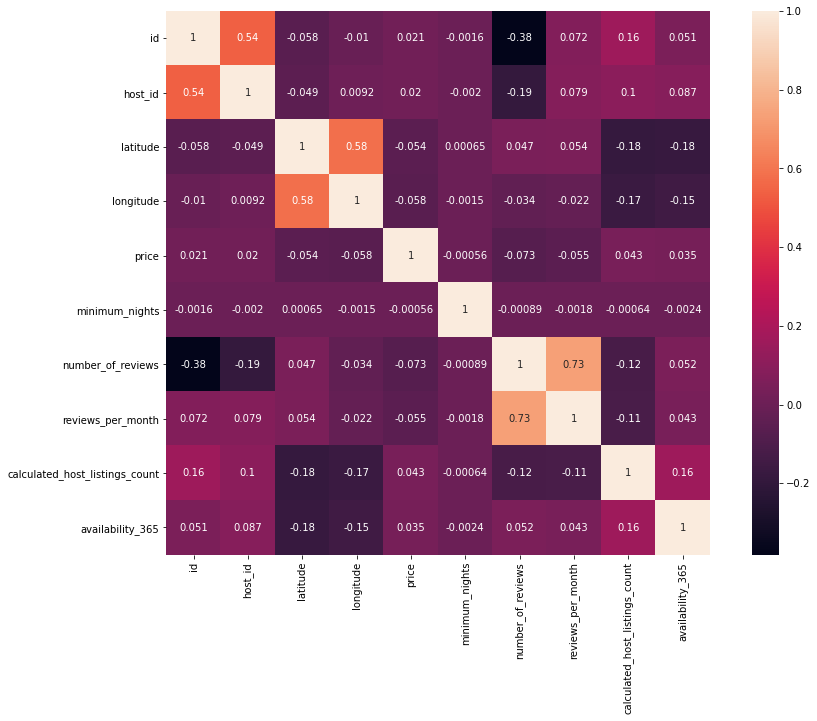

In [33]:
# citation 3
corrmat = df.corr()
corrmat.head()
fig = plt.figure(figsize = (15,10))
sns.heatmap(corrmat,square = True,annot = True)
plt.show()

Firstly, I explored the correlation of the variables in the dataset to each other. As expected, longitude and latitude have some correlation, as well as number_of_reviews and reviews_per_month. Therefore, I would use either of those variables but not both and since reviews_per_month has a lot of missing values, it is more preferable to use number_of_reviews. The variables calculated_host_listings_count and availability_365 have slight correlation to each other, however, they are also both correlated to price.

##### Distribution of numerical variables

In [ ]:
# citation 2
fig, axes = plt.subplots(nrows=2, ncols=3)
fig.set_figheight(10)
fig.set_figwidth(20)
numerical_variables = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']
current_var = 0
for row in axes:
    for col in row:
        voi = numerical_variables[current_var] # variable of interest
        df[voi].plot(kind='kde', ax=col, xlim=(min(df[voi]), max(df[voi])))
        col.set_title(voi +' Distribution', fontsize=16)
        current_var += 1

| Column Name                    | Mean | Standard Deviation | 75% Quantile   | Max       |
|--------------------------------|------|--------------------|----------------|-----------|
| price                          | 220  | 570                | 201            | 25000     |
| minimum_nights                 | 453  | 210000             | 7             | 100000000 |
| number_of_reviews              | 34.5 | 63.6               | 39             | 966       |
| reviews_per_month              | 1.43 | 1.68               | 2.06           | 44.1      |
| calculated_host_listings_count | 16.7 | 51.1               | 6              | 593       |
| availability_365               | 159  | 140                | 311            | 365       |

Next, I looked the distributions of the numerical variables by plotting them from their minimum to maximum values. The price has most of its observations in between 0-1000 USD and therefore, there is a big left skew in our outcome variable. This is also present in reviews_per_month and calculated_host_listings_count, therefore it can be said that all of these variables contain massive outliers (datapoints more than 2 standard deviations from the mean). The minimum_nights variable contains an observation in the millions, which means this variable also has massive outliers. The availability_365 variable seems to be multi-modal, but the values are inbetween 0 and 365, which means there are no outliers in this column.

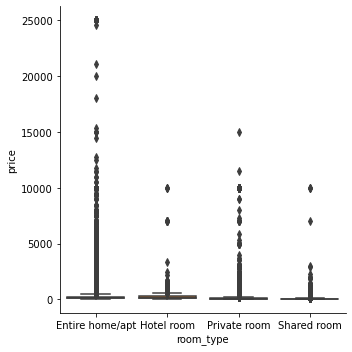

In [28]:
sns.catplot(x='room_type', y='price', kind='box', data=df)

In [ ]:
In order to further explore the 

##### One-Hot Encoding for categorical variables

In [44]:
# dropping neighbourhood group as it has many missing values
df = df.drop('neighbourhood_group', axis=1)

# transforming object columns to category
df['city'] = df['city'].astype('category')
df['room_type'] = df['room_type'].astype('category')
df['neighbourhood'] = df['neighbourhood'].astype('category')

# one-hot encoding
room_type = df['room_type']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_room_type = OH_encoder.fit_transform([room_type])
encoded_room_type = pd.DataFrame(numpy.transpose(encoded_room_type))

city = df['city']
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
encoded_city = OH_encoder.fit_transform([city])
encoded_city = pd.DataFrame(numpy.transpose(encoded_city))

# Models

The models that I explored are Decision Trees and Random Forests. Since my outcome variable (price) was continuous, I used the regressor version of these models. 

In [50]:
# our features and independant variables
feature_list = ['latitude', 'longitude','number_of_reviews','availability_365']
X = df[feature_list]
y = df['price']

# Add one-hot encoded columns to numerical features
X = pd.concat([X, encoded_city, encoded_room_type], axis=1)

# splitting into training and testing sets
train_X, valid_X, train_y, valid_y = train_test_split(X, y, random_state = 1)
#train_ohe_X, valid_ohe_X, train_ohe_y, valid_ohe_y = train_test_split(ohe_X, y, random_state = 1)

##### Decision Tree Regressor

In [51]:
# model building
model = DecisionTreeRegressor(random_state=1)
model.fit(train_X,train_y)

# model predictions
dt_predictions = model.predict(valid_X)
print("RMSE: ", mean_squared_error(valid_y, dt_predictions, squared=False))

RMSE:  702.3088526673574


##### Random Forest Regressor

In [ ]:
# model building
forest_model = RandomForestRegressor(n_estimators=500, random_state=1)
forest_model.fit(X, train_y)

# model predictions
rf_predictions = forest_model.predict(valid_X)
print('RMSE for RF: ', mean_squared_error(valid_y, rf_predictions, squared=False))

Multi-Layer Perceptron

In [24]:
mlp_regr = MLPRegressor(random_state=1, max_iter=1000).fit(X, y_train)
predictions = regr.predict(valid_X)
print("RMSE for MLP: " + str(mean_squared_error(predictions, y_valid, squared=False)))

RMSE: 577.0233587178686


##### K-fold validation

In [52]:
my_pipeline = Pipeline(steps=[('preprocessor', SimpleImputer()),
                              ('model', RandomForestRegressor(n_estimators=500,
                                                              random_state=0))
                             ])

from sklearn.model_selection import cross_val_score

# Multiply by -1 since sklearn calculates *negative* MAE
scores = -1 * cross_val_score(my_pipeline, X, y,
                              cv=5,
                              scoring='neg_mean_squared_error')
import math
for i, score in enumerate(scores):
    scores[i] = math.sqrt(score)
    
print("RMSE scores:\n", scores)
print(scores.mean())

RMSE scores:
 [ 550.71411737 3036.49604442  400.1285955   389.67692569  794.57981064]
1034.3190987243338


# Results

# Citations

1) Kaggle Courses: "Introduction to Machine Learning" and "Intermediate Machine Learning". Code is referenced from here.

2) https://www.kaggle.com/thomaskonstantin/u-s-airbnb-analysis-and-price-prediction. Code is referenced from this notebook for the purposes of data analysis.

3) https://www.kaggle.com/ojaswagarg/nlp-to-get-over-90-regression-score. Code is referenced from this notebook for the purposes of data analysis.

In [57]:
# evaluate RFE for regression
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

# create pipeline
rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=4)
model = DecisionTreeRegressor()
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')

import math
mean_scores=[]
for i, score in enumerate(n_scores):
    mean_scores.append(math.sqrt(-1 * score))
    
# report performance
print('RMSE: %.3f (%.3f)' % (mean(mean_scores), std(n_scores)))

RMSE: 702.727 (59195.452)
